**Мы имеем:**
1. Два фильтра из трех.
algos.csv: две строки по 9 чисел — уцелевшие фильтры.
2. Входные изображения в одноканальном формате
Изображения (.png), которые использовались как вход.
3. Числовые матрицы — результат применения всех трех фильтров к этим изображениям (в виде .txt файлов, сохранённых через numpy.savetxt).

Каждому входному FILENAME.png файлу соответствует выходной FILENAME.txt.


Каждый фильтр — это матрица 3×3, применяемая к изображению по скользящему окну:
поэлементное произведение окна и фильтра → сумма → в соответствующую ячейку выходной матрицы. Алгоритм последовательно применяет три таких фильтра ко всему изображению.

**Задача** — восстановить недостающий фильтр и порядок применения всех трёх.
От вас ожидается восстановленный алгоритм в формате reconstructed_algos.csv, содержащем три строки по 9 чисел через запятую, в порядке применения фильтров. Первая строка соответствует первому фильтру, вторая второму, третья третьему.

Важно:
Точный ответ не требуется: оценивается среднее значение MSE между вашими фильтрами и оригинальными.

In [69]:
!mkdir best_pictures
!tar -xvf best_pictures.tar -C /content/best_pictures/ > /dev/null 2>&1

mkdir: cannot create directory ‘best_pictures’: File exists


In [70]:
import numpy as np
from scipy.signal import correlate2d
from PIL import Image
import os
from itertools import permutations
import torch
import torch.nn as nn
import torch.optim as optim

# Загрузка известных фильтров
known_filters = np.loadtxt('best_pictures/algos.csv', delimiter=',')
F1 = known_filters[0].reshape(3, 3)
F2 = known_filters[1].reshape(3, 3)

# Загрузка изображений и выходных матриц
image_folder = 'best_pictures'
output_files = [f for f in os.listdir(image_folder) if f.endswith('.txt') and not f.startswith('.')]

file_image_output_pairs = []

for f in output_files:
    file_index = int(f.split('.')[0])
    img_name = f.replace('.txt', '.png')
    img_path = os.path.join(image_folder, img_name)

    if not os.path.exists(img_path):
        continue

    img = np.array(Image.open(img_path))
    output = np.loadtxt(os.path.join(image_folder, f))

    file_image_output_pairs.append((file_index, f, img, output))

file_image_output_pairs.sort(key=lambda x: x[0])
_, output_files, images, outputs = zip(*file_image_output_pairs)
images = list(images)
outputs = list(outputs)

In [71]:
F1

array([[-1. , -0.5,  0. ],
       [-0.5,  0.5,  0.5],
       [ 0. ,  0.5,  1. ]])

In [72]:
F2

array([[0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625]])

In [73]:
# Определение устройства (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Преобразование списков изображений и выходов в тензоры
X = torch.tensor(np.array(images), dtype=torch.float32).unsqueeze(1).to(device)  # (N, 1, H, W)
Y = torch.tensor(np.array(outputs), dtype=torch.float32).unsqueeze(1).to(device)  # (N, 1, H, W)

best_mse = float('inf')
best_order = None
best_missing_filter = None

# Генерация случайных начальных весов для F3 (одинаковых для всех моделей)
torch.manual_seed(42)  # Фиксируем seed для воспроизводимости
initial_F3_weights = torch.randn(1, 1, 3, 3).to(device)  # Случайные веса размером (1, 1, 3, 3)

# Список для хранения лоссов всех моделей
all_losses = []

# Перебор всех возможных порядков фильтров
for perm_index, perm in enumerate(permutations([('F1', F1), ('F2', F2), ('F3', None)])):
    order_names = [p[0] for p in perm]
    print(f"\nТекущий порядок: {order_names}")

    # Создание модели
    class ConvModel(nn.Module):
        def __init__(self):
            super(ConvModel, self).__init__()
            self.layers = []
            for name, filt in perm:
                if name == 'F3':
                    # Обучаемый фильтр с фиксированными случайными начальными весами
                    conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
                    with torch.no_grad():
                        conv.weight.copy_(initial_F3_weights)  # Установка начальных весов
                else:
                    # Фиксированный фильтр
                    conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
                    with torch.no_grad():
                        # Преобразуем filt в тензор PyTorch, если это массив NumPy
                        if isinstance(filt, np.ndarray):
                            filt = torch.tensor(filt, dtype=torch.float32)
                        conv.weight.copy_(filt)
                        conv.weight.requires_grad = False  # Заморозка весов
                self.layers.append(conv)
            self.layers = nn.ModuleList(self.layers)

        def forward(self, x):
            for layer in self.layers:
                x = layer(x)
            return x

    model = ConvModel().to(device)  # Перемещение модели на GPU
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.05)

    # Вывод начальных весов F3
    for i, (name, _) in enumerate(perm):
        if name == 'F3':
            initial_weights = model.layers[i].weight.data.cpu().numpy().squeeze()  # Перемещение на CPU для вывода
            print(f"Начальные веса F3:\n{initial_weights}")

    # Обучение
    print("Начало обучения:")
    losses_for_this_model = []  # Лоссы для текущей модели
    for epoch in range(2000):
        model.train()
        optimizer.zero_grad()
        outputs1 = model(X)
        loss = criterion(outputs1, Y)
        loss.backward()
        optimizer.step()

        # Сохранение лосса
        losses_for_this_model.append(loss.item())

        # Вывод каждые 10 эпох
        if (epoch + 1) % 500 == 0:
            print(f"Эпоха [{epoch+1}/2000], Лосс: {loss.item():.6f}")

    # Оценка
    model.eval()
    with torch.no_grad():
        preds = model(X)
        mse = criterion(preds, Y).item()

    print(f"MSE после обучения: {mse:.10f}")

    # Сохранение лучшего результата
    if mse < best_mse:
        print(f"Найдено улучшение! Новый лучший MSE: {mse:.10f}")
        best_mse = mse
        best_order = order_names
        # Сохранение весов F3
        for i, (name, _) in enumerate(perm):
            if name == 'F3':
                best_missing_filter = model.layers[i].weight.data.cpu().numpy().squeeze()  # Перемещение на CPU для сохранения

    # Сохранение лоссов для текущей модели
    all_losses.append((order_names, losses_for_this_model))

Используемое устройство: cuda

Текущий порядок: ['F1', 'F2', 'F3']
Начальные веса F3:
[[ 0.33669037  0.1288094   0.23446237]
 [ 0.23033303 -1.1228564  -0.18632829]
 [ 2.2082014  -0.63799703  0.46165723]]
Начало обучения:
Эпоха [500/2000], Лосс: 901.679443
Эпоха [1000/2000], Лосс: 895.646118
Эпоха [1500/2000], Лосс: 891.149719
Эпоха [2000/2000], Лосс: 887.918518
MSE после обучения: 887.9135131836
Найдено улучшение! Новый лучший MSE: 887.9135131836

Текущий порядок: ['F1', 'F3', 'F2']
Начальные веса F3:
[[ 0.33669037  0.1288094   0.23446237]
 [ 0.23033303 -1.1228564  -0.18632829]
 [ 2.2082014  -0.63799703  0.46165723]]
Начало обучения:
Эпоха [500/2000], Лосс: 921.638428
Эпоха [1000/2000], Лосс: 916.156677
Эпоха [1500/2000], Лосс: 911.948608
Эпоха [2000/2000], Лосс: 908.916992
MSE после обучения: 908.9123535156

Текущий порядок: ['F2', 'F1', 'F3']
Начальные веса F3:
[[ 0.33669037  0.1288094   0.23446237]
 [ 0.23033303 -1.1228564  -0.18632829]
 [ 2.2082014  -0.63799703  0.46165723]]
Начало


Результаты:
Лучший порядок: ['F2', 'F3', 'F1']
Лучший MSE: 0.000021

Итоговые веса F3:
[[0.12462361  0.25086498  0.1244535  ]
 [0.25039902  0.49874333  0.25087267 ]
 [0.12493083  0.2503989   0.124620095]]


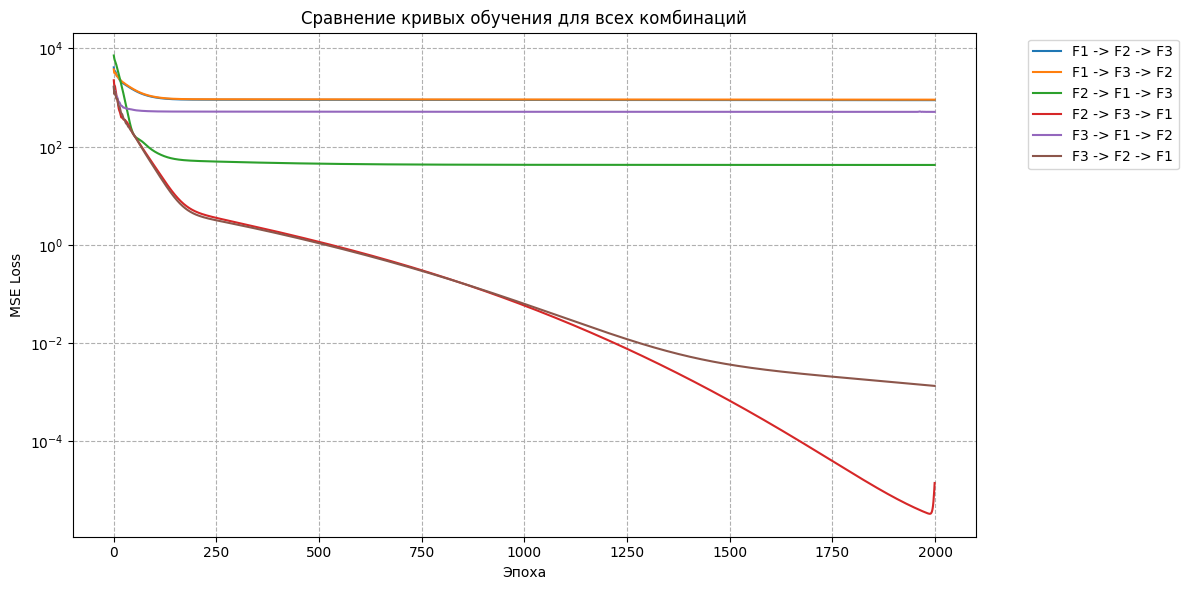

In [75]:
import matplotlib.pyplot as plt

# Вывод результатов
print("\nРезультаты:")
print(f"Лучший порядок: {best_order}")
print(f"Лучший MSE: {best_mse:.6f}")

# Вывод итоговых весов F3
if best_missing_filter is not None:
    print("\nИтоговые веса F3:")
    print(best_missing_filter)

plt.figure(figsize=(12, 6))
for order_names, losses in all_losses:
    label = ' -> '.join(order_names)
    plt.plot(losses, label=label)

plt.title('Сравнение кривых обучения для всех комбинаций')
plt.xlabel('Эпоха')
plt.ylabel('MSE Loss')
plt.yscale('log')  # Логарифмическая шкала для лучше визуализации
plt.grid(True, which="both", ls="--")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [76]:
best_missing_filter

array([[0.12462361 , 0.25086498 , 0.1244535  ],
       [0.25039902 , 0.49874333 , 0.25087267 ],
       [0.12493083 , 0.2503989  , 0.124620095]], dtype=float32)

можно поиграться с гиперпараметрами и получить более точные веса при которых фильтр будет такой: 

[0.125, 0.25, 0.125] </br>
[0.25, 0.5, 0.25 ] </br>
[0.125, 0.25, 0.125] </br>


In [77]:
def apply_convolution(image, filters):
    result = image.astype(np.float64)
    for f in filters:
        result = correlate2d(result, f.astype(np.float64), mode='same')
    return result

np.set_printoptions(precision=15, suppress=False)

F3 = best_missing_filter

F3_rounded = np.array([[0.125, 0.25, 0.125],
                       [0.25, 0.5, 0.25],
                       [0.125, 0.25, 0.125]], dtype=np.float64)

print(apply_convolution(images[0], [F2, F3_rounded, F1]))

[[ 324.81640625  364.234375    353.43359375 ...  326.73828125
   229.59765625   33.4296875 ]
 [ 339.8203125   287.3828125   229.90234375 ...  166.51953125
    54.49609375 -134.234375  ]
 [ 289.40234375  188.03515625  113.96484375 ...   55.84765625
   -46.609375   -207.77734375]
 ...
 [ 227.94921875  131.46875      66.82421875 ...   20.4140625
   -33.46484375 -130.69140625]
 [ 158.03125      54.953125     -8.49609375 ...  -30.85546875
   -69.5234375  -135.56640625]
 [  23.84765625  -83.91796875 -141.98828125 ... -111.99609375
  -124.3828125  -131.65234375]]


In [78]:
print(outputs[0])

[[ 324.81640625  364.234375    353.43359375 ...  326.73828125
   229.59765625   33.4296875 ]
 [ 339.8203125   287.3828125   229.90234375 ...  166.51953125
    54.49609375 -134.234375  ]
 [ 289.40234375  188.03515625  113.96484375 ...   55.84765625
   -46.609375   -207.77734375]
 ...
 [ 227.94921875  131.46875      66.82421875 ...   20.4140625
   -33.46484375 -130.69140625]
 [ 158.03125      54.953125     -8.49609375 ...  -30.85546875
   -69.5234375  -135.56640625]
 [  23.84765625  -83.91796875 -141.98828125 ... -111.99609375
  -124.3828125  -131.65234375]]


array([[174, 160, 172, ..., 182, 223, 244],
       [213, 226, 184, ..., 223, 217, 154],
       [163, 202, 194, ..., 165, 127, 135],
       ...,
       [137, 131, 122, ...,  99, 100, 114],
       [136, 129, 118, ...,  85,  89, 112],
       [132, 125, 117, ...,  73,  91, 109]], dtype=uint8)
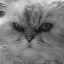

In [79]:
images[0]

In [80]:
def mse(matrix1, matrix2):
    # Преобразуем входные данные в массивы NumPy
    matrix1 = np.asarray(matrix1, dtype=np.float64)
    matrix2 = np.asarray(matrix2, dtype=np.float64)
    # Приводим размерности к одной форме
    matrix1 = np.squeeze(matrix1)  # Убираем оси длиной 1
    matrix2 = np.squeeze(matrix2)  # Убираем оси длиной 1
    if matrix1.shape != matrix2.shape:
        raise ValueError(f"Размеры матриц не совпадают: {matrix1.shape} vs {matrix2.shape}")
    return np.mean(np.square(matrix1 - matrix2))

# Преобразование тензоров в массивы NumPy
image_np = images[0].cpu().detach().numpy() if isinstance(images[0], torch.Tensor) else images[0]
output_np = outputs[0].cpu().detach().numpy() if isinstance(outputs[0], torch.Tensor) else outputs[0]

print(f"MSE: {mse(apply_convolution(image_np, [F2, F3_rounded, F1]), output_np):.15e}")
print(f"MSE: {mse(apply_convolution(image_np, [F2, F3, F1]), output_np):.15e}")

MSE: 0.000000000000000e+00
MSE: 2.051396605071579e-05


In [1]:
image_np = images[0].detach().numpy() if isinstance(images[0], torch.Tensor) else images[0]
output_np = outputs[0].detach().numpy() if isinstance(outputs[0], torch.Tensor) else outputs[0]

s1 = 0
s2 = 0
for i in range(len(images)):
  s1 += mse(apply_convolution(image_np, [F2, F3, F1]), output_np)
  s2 += mse(apply_convolution(image_np, [F2, F3_rounded, F1]), output_np)

print(s2) # F3_rounded
print(s1) # F3

0.0
0.02051396605071589
